In [1]:
%matplotlib inline

In [2]:
import timeit

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from navi import bearing_to_waypoint, rumbline_distance
from utils import prepare_dataframe, generate_training_dataframe, cartesian_to_geo, get_direction_from_sin_cos, split_dataframe, manage_prediction, plot_tds, create_real_pred_df, probability_within_radius

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import train_test_split, GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# Draft Training and testing of models on predicting tropical depression, originating aa North pacific ocean

In [3]:
nhc = pd.read_csv('data/csv_ready/ne_pacific_td.csv')

In [4]:
nhc

,date,basin,name,consecutive_count,type_of_depression,lat,lon,max_wind_kn,min_pressure_mBar
0,1949-06-17 12:00:00,EP,UNNAMED,25,TS,14.1,253.0,45.0,-999.0
1,1949-06-17 18:00:00,EP,UNNAMED,25,TS,14.6,252.3,45.0,-999.0
2,1949-06-18 00:00:00,EP,UNNAMED,25,TS,15.0,251.6,45.0,-999.0
3,1949-06-18 06:00:00,EP,UNNAMED,25,TS,15.4,250.8,45.0,-999.0
4,1949-06-18 12:00:00,EP,UNNAMED,25,TS,15.7,250.0,45.0,-999.0
...,...,...,...,...,...,...,...,...,...
31168,2023-11-26 12:00:00,EP,RAMON,25,LO,14.4,236.3,30.0,1006.0
31169,2023-11-26 18:00:00,EP,RAMON,25,LO,14.3,236.0,25.0,1008.0
31170,2023-11-27 00:00:00,EP,RAMON,25,LO,14.1,235.6,25.0,1008.0
31171,2023-11-27 06:00:00,EP,RAMON,25,LO,13.8,235.3,25.0,1008.0


In order to prepare the data for the model, we need to c/out data cleaning. Removing columns which are irelevant

In [5]:
nhc = nhc.drop(columns=['basin', 'consecutive_count', 'type_of_depression'])

In [6]:
nhc.date = pd.to_datetime(nhc.date)

In [7]:
(nhc.date[1] - nhc.date[0])

Timedelta('0 days 06:00:00')

In [8]:
jma = pd.read_csv('data/csv_ready/jma_td.csv', index_col=0)

In [9]:
jma

,category,lat,lon,min_pressure_mBar,max_wind_kn,name
date,,,,,,
1951-02-19 06:00:00,2,20.0,138.5,1010,0,NaN
1951-02-19 12:00:00,2,20.0,138.5,1010,0,NaN
1951-02-19 18:00:00,2,23.0,142.1,1000,0,NaN
1951-02-20 00:00:00,9,25.0,146.0,994,0,NaN
1951-02-20 06:00:00,9,27.6,150.6,994,0,NaN
...,...,...,...,...,...,...
2023-12-17 06:00:00,3,7.5,129.6,1002,35,JELAWA
2023-12-17 12:00:00,3,7.4,128.5,1002,35,JELAWA
2023-12-17 18:00:00,3,7.4,127.4,1002,35,JELAWA


In [10]:
jma = jma.drop(columns='category')

In [11]:
jma.index = pd.to_datetime(jma.index)

Following will be c/out:
1. drop columns
2. if name is NaN, change to UNNAMED
3. calculate velocity, direction of movement
4. normalize(transform) direction into sin and cosin
5. normalize velocity
6. transform coordinates to cartesian

To transform geographic coordinates (latitude and longitude) into a trigonometric coordinate system, such as Cartesian coordinates (x, y, z), you can use a common spherical-to-Cartesian conversion. This transformation assumes the Earth as a sphere and projects the coordinates onto a 3D Cartesian system. Here’s how you can transform latitude and longitude into 
𝑥
x, 
𝑦
y, and 
𝑧
z coordinates:

Transformation Formulas:
Given:

lat
lat: Latitude in degrees
lon
lon: Longitude in degrees
You can convert latitude and longitude into 
𝑥
x, 
𝑦
y, and 
𝑧
z using the following formulas:

Convert latitude and longitude into radians:

𝜙
=
lat
×
𝜋
180
ϕ=lat× 
180
π
​
 
𝜆
=
lon
×
𝜋
180
λ=lon× 
180
π
​
 
Where 
𝜙
ϕ is latitude in radians and 
𝜆
λ is longitude in radians.

Calculate 
𝑥
x, 
𝑦
y, and 
𝑧
z assuming a unit sphere (Earth's radius is 1):

𝑥
=
cos
⁡
(
𝜙
)
×
cos
⁡
(
𝜆
)
x=cos(ϕ)×cos(λ)
𝑦
=
cos
⁡
(
𝜙
)
×
sin
⁡
(
𝜆
)
y=cos(ϕ)×sin(λ)
𝑧
=
sin
⁡
(
𝜙
)
z=sin(ϕ)

Explanation:
Latitude (lat): Measures the angle above or below the equator.
Longitude (lon): Measures the angle east or west of the prime meridian.
The trigonometric transformation projects these angles into a Cartesian 3D space using cosine and sine functions. This helps convert the Earth’s surface (which is spherical) into a Cartesian coordinate system.
What the 
𝑥
x, 
𝑦
y, 
𝑧
z Coordinates Represent:
𝑥
x, 
𝑦
y, and 
𝑧
z represent the position on a unit sphere where the radius is 1.
The benefit of using 
𝑥
x, 
𝑦
y, and 
𝑧
z instead of latitude and longitude is that the machine learning model can learn patterns more effectively in a continuous space rather than separate angular features.
After this transformation, your ML model will work with 
𝑥
x, 
𝑦
y, and 
𝑧
z instead of lat/lon as separate features, preserving the spatial relationships in a more mathematically continuous way.






You said:
how about the reverse transformation?
ChatGPT said:
ChatGPT
To convert Cartesian coordinates (
𝑥
x, 
𝑦
y, 
𝑧
z) back to geographic coordinates (latitude and longitude), you can use the reverse spherical transformation. This involves converting the 3D Cartesian coordinates back into angles representing latitude and longitude.

Reverse Transformation Formulas:
Given Cartesian coordinates 
𝑥
x, 
𝑦
y, and 
𝑧
z:

Calculate the latitude (
lat
lat):

lat
=
arcsin
⁡
(
𝑧
𝑥
2
+
𝑦
2
+
𝑧
2
)
lat=arcsin( 
x 
2
 +y 
2
 +z 
2
 
​
 
z
​
 )
Since the unit sphere assumption means 
𝑥
2
+
𝑦
2
+
𝑧
2
=
1
x 
2
 +y 
2
 +z 
2
 
​
 =1, this simplifies to:

lat
=
arcsin
⁡
(
𝑧
)
lat=arcsin(z)
Calculate the longitude (
lon
lon):

lon
=
arctan
⁡
2
(
𝑦
,
𝑥
)
lon=arctan2(y,x)
The arctan2 function is used to correctly compute the angle in all quadrants, considering both 
𝑥
x and 
𝑦
y values.

Convert latitude and longitude from radians back to degrees:

lat
=
lat
×
180
𝜋
lat=lat× 
π
180
​
 
lon
=
lon
×
180
𝜋
lon=lon× 
π
180
​


Explanation:
Latitude is calculated using the inverse sine (
arcsin
⁡
arcsin) of 
𝑧
z, as the vertical component directly corresponds to latitude on a unit sphere.
Longitude is derived using the 
arctan
⁡
2
(
𝑦
,
𝑥
)
arctan2(y,x), which correctly computes the angle in all quadrants. This gives you the correct longitude based on the 
𝑥
x and 
𝑦
y coordinates.
Conversion to degrees is required because the 
arcsin
⁡
arcsin and 
arctan
⁡
2
arctan2 functions return results in radians.
Use Case:
This reverse transformation is helpful if you want to transform your machine learning model's predictions (which could be in Cartesian coordinates) back into geographic latitude and longitude coordinates for easy interpretation and mapping.

By combining both transformations (from geo to Cartesian and back), you ensure that geographic patterns in latitude and longitude are represented effectively for machine learning models, while still being able to interpret the results in traditional geographic terms.

Feature engineering velocity and direction can be valuable, even though they are related to the coordinates. Here’s why they might still add value:

1. Why Velocity and Direction Can Be Valuable:
Velocity (speed of movement) and direction (bearing) capture the dynamics of the tropical depression (TD) over time. They provide insight into how fast and in what direction the TD is moving, which isn't always directly obvious from the raw coordinates.
These features simplify complex relationships: Latitude and longitude alone are static points. Velocity and direction help capture temporal changes in location, which could be valuable for predicting future positions.
Machine learning models sometimes benefit from derived features that highlight trends or movements explicitly, even if those features could technically be derived from other data (like coordinates).
2. Velocity and Direction Calculations:
Velocity measures the speed between two consecutive points (how fast the TD is moving).
Direction (or bearing) measures the angle of movement between two consecutive points (in which direction the TD is moving).
3. How They Add Value:
Velocity is important in tracking how fast the tropical depression intensifies or weakens. Fast-moving TDs might behave differently than slow-moving ones.
Direction is important because storms typically follow specific paths, and shifts in direction could indicate environmental changes (such as steering winds) that affect the storm's future track.
4. Feature Redundancy Concern:
While velocity and direction are derived from coordinates, they summarize movement in a way that’s often easier for the model to interpret than raw coordinate changes.
If the model uses temporal information (like changes in coordinates over time), it might implicitly capture velocity and direction. However, explicitly adding them as features can make it easier for the model to learn these dynamics directly.
5. Why They Might Not Add Value:
If the model is already sophisticated enough to learn patterns from raw coordinates and time differences (e.g., in a sequence model like LSTM), then manually calculated velocity and direction might be redundant.
In simpler models (like decision trees), these engineered features could be more valuable.
Practical Approach:
You could try both approaches:

Train a model with just the coordinates and time.
Train another model with coordinates, time, velocity, and direction as additional features.
Then compare the performance of both models. If velocity and direction improve accuracy or interpretability, they are valuable. If not, they might be redundant in your specific case.

6. How to Calculate Velocity and Direction:
Velocity: The distance between two consecutive geographic points over a time period.
Direction: The angle (bearing) between two consecutive geographic points.

You're correct! Since direction (direction_deg) represents an angular value (e.g., compass direction), it behaves differently than continuous numerical features and should not be normalized the same way as features like velocity. Angular data has cyclic properties, where 0 degrees is equivalent to 360 degrees, which makes direct normalization problematic.

How to handle direction_deg:
Instead of normalizing it like a typical numerical feature, you can transform the direction into two separate features representing sine and cosine of the angle. This technique captures the cyclical nature of the data.

Why this approach works:
Sine and cosine represent the circular nature of angles, ensuring the model can interpret the closeness between directions like 0° and 360°.
By splitting the angle into two components, the model can better understand the cyclical relationship between directions.
Example:
0° becomes (sin(0°), cos(0°)) = (0, 1)
90° becomes (sin(90°), cos(90°)) = (1, 0)
180° becomes (sin(180°), cos(180°)) = (0, -1)
360° becomes (sin(360°), cos(360°)) = (0, 1) — same as 0°
This transformation is essential when working with angular data to prevent issues that arise from the cyclic nature of angles, and it also ensures that the model treats directions correctly.

Handling velocity:
For velocity, you can still normalize it using either Min-Max Scaling or Z-Score Normalization as described earlier.

This way, you ensure that direction is handled appropriately as a cyclical feature, and velocity is properly normalized as a continuous feature.

To reverse the transformation from sine and cosine back to the direction in degrees, you can use the atan2 function, which computes the arctangent of the quotient of its arguments (in this case, the sine and cosine components). The atan2 function is helpful because it considers the sign of both inputs to determine the correct quadrant for the angle.

Here’s how you can convert sine and cosine values back to the original direction (in degrees):

In [12]:
# if name is NaN, change to UNNAMED
jma['name'] = jma['name'].apply(lambda x: 'UNNAMED' if pd.isna(x) else x)

In [13]:
jma = jma.drop(jma.index[0])

In [14]:
def geo_to_cartesian(df):
    """
    Transforms latitude and longitude into Cartesian coordinates (x, y, z).
    
    Parameters:
        df (pandas.DataFrame): DataFrame with 'lat' and 'lon' columns.
    
    Returns:
        pandas.DataFrame: DataFrame with added 'x', 'y', 'z' columns.
    """
    # Convert lat/lon from degrees to radians
    lat_rad = np.radians(df['lat'])
    lon_rad = np.radians(df['lon'])

    # Compute x, y, z using spherical to Cartesian transformation
    df['x'] = np.cos(lat_rad) * np.cos(lon_rad)
    df['y'] = np.cos(lat_rad) * np.sin(lon_rad)
    df['z'] = np.sin(lat_rad)

    # df = df.drop(columns=['lat', 'lon'])

    return df

def cartesian_to_geo(df):
    """
    Transforms Cartesian coordinates (x, y, z) back to latitude and longitude.
    
    Parameters:
        df (pandas.DataFrame): DataFrame with 'x', 'y', 'z' columns.
    
    Returns:
        pandas.DataFrame: DataFrame with added 'lat' and 'lon' columns.
    """
    # Calculate latitude (in radians)
    df['lat'] = np.degrees(np.arcsin(df['z']))
    
    # Calculate longitude (in radians), using arctan2 to handle all quadrants
    df['lon'] = np.degrees(np.arctan2(df['y'], df['x']))

    df = df.drop(columns=['x', 'y', 'z'])
    
    return df

def calculate_velocity_direction(df):
    """
    Calculates velocity (kn) and direction (bearing in degrees) between consecutive points.
    """
    velocity = np.zeros(len(df))
    direction = np.zeros(len(df))
    
    for i in range(len(df)):
        # velocity and direction for the first record
        if i == 0:
            velocity[i] = 0
            direction[i] = 0
            continue

        # check previous name is different from current name
        previous_name = df.iloc[i-1]['name']
        current_name = df.iloc[i]['name']
        
        if current_name != previous_name:
            velocity[i] = 0
            direction[i] = 0
            continue
        
        # Get the previous and current coordinates
        prev_point = (df.iloc[i-1]['lat'], df.iloc[i-1]['lon'])
        curr_point = (df.iloc[i]['lat'], df.iloc[i]['lon'])
        
        # Calculate distance in nautical miles
        distance = rumbline_distance(prev_point, curr_point)
        
        # Calculate time difference in hours
        time_diff = (df.index[i] - df.index[i-1]).seconds / 3600
        
        # Calculate velocity in kn
        if distance == 0 or time_diff ==0:
            velocity[i] = 0
        else:
            velocity[i] = distance / time_diff
        
        # Calculate direction (bearing)
        direction[i] = bearing_to_waypoint(prev_point, curr_point)
    
        
    df.loc[:, 'velocity_kn'] = velocity
    df.loc[:, 'direction_deg'] = direction
    
    return df

def convert_direction_to_sin_cosin(df):
    direction_rad = np.deg2rad(df['direction_deg'])

    # Create sine and cosine components
    df['direction_sin'] = np.sin(direction_rad)
    df['direction_cos'] = np.cos(direction_rad)
    
    # Drop the original direction column if it's no longer needed
    # df = df.drop(columns=['direction_deg'])

    return df

def get_direction_from_sin_cos(sin_val, cos_val):
    """
    Reversed bearing in degrees from sin and cosin values.

    Usage:
    df['direction_deg_reversed'] = df.apply(lambda row: get_direction_from_sin_cos(row['direction_sin'], row['direction_cos']), axis=1)
    """
    # Get the angle in radians
    angle_rad = np.arctan2(sin_val, cos_val)
    
    # Convert radians to degrees
    angle_deg = np.degrees(angle_rad)
    
    # Make sure the angle is within the range 0° to 360°
    if angle_deg < 0:
        angle_deg += 360

    return angle_deg

In [15]:
# calculate velocity and direction
jma = calculate_velocity_direction(jma)

In [16]:
# normalize direction
jma = convert_direction_to_sin_cosin(jma)

In [17]:
jma = geo_to_cartesian(jma)

In [18]:
# normalize velocity
scaler = MinMaxScaler()

jma['velocity_kn'] = scaler.fit_transform(jma[['velocity_kn']])

In [19]:
jma

,lat,lon,min_pressure_mBar,max_wind_kn,name,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,
1951-02-19 12:00:00,20.0,138.5,1010,0,UNNAMED,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,23.0,142.1,1000,0,UNNAMED,0.236022,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,25.0,146.0,994,0,UNNAMED,0.212349,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,27.6,150.6,994,0,UNNAMED,0.256478,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,28.9,153.3,994,0,UNNAMED,0.141970,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,7.5,129.6,1002,35,JELAWA,0.046522,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526
2023-12-17 12:00:00,7.4,128.5,1002,35,JELAWA,0.055310,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796
2023-12-17 18:00:00,7.4,127.4,1002,35,JELAWA,0.055087,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796


In [20]:
jma.groupby(jma.min_pressure_mBar).max_wind_kn.value_counts()

min_pressure_mBar  max_wind_kn
870                140             1
875                0               2
                   120             1
877                0               2
878                0               2
                                  ..
1015               0               2
1016               0              50
1018               0              17
1020               0               3
1022               0               1
Name: count, Length: 361, dtype: int64

In [21]:
jma.groupby(jma.max_wind_kn).min_pressure_mBar.min()

max_wind_kn
0      875
35     980
40     975
45     970
50     965
55     965
60     955
65     950
70     935
75     940
80     915
85     920
90     905
95     915
100    900
105    905
110    885
115    895
120    875
125    885
130    900
140    870
Name: min_pressure_mBar, dtype: int64

In [22]:
# Apply a condition to set max_wind_kn to 35 where pressure is greater than or equal to 980
jma.loc[jma['min_pressure_mBar'] >= 980, 'max_wind_kn'] = 35

Basis above separation, we will complete the missing data. As seen on the DS, in the first stages of TD, the wind record is 0. We will set that to 35 kn for concistency.

In [23]:
jma['min_pressure_mBar'] = scaler.fit_transform(jma[['min_pressure_mBar']])

In [24]:
jma.max_wind_kn.value_counts()

max_wind_kn
35     49547
0       6743
70      1909
75      1631
80      1605
65      1565
60      1486
85      1291
90      1033
95       680
100      631
55       344
105      243
110      237
50       181
115       79
120       45
45        35
125        9
40         4
130        3
140        1
Name: count, dtype: int64

In [25]:
jma

,lat,lon,min_pressure_mBar,max_wind_kn,name,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,
1951-02-19 12:00:00,20.0,138.5,0.921053,35,UNNAMED,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,23.0,142.1,0.855263,35,UNNAMED,0.236022,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,25.0,146.0,0.815789,35,UNNAMED,0.212349,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,27.6,150.6,0.815789,35,UNNAMED,0.256478,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,28.9,153.3,0.815789,35,UNNAMED,0.141970,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,7.5,129.6,0.868421,35,JELAWA,0.046522,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526
2023-12-17 12:00:00,7.4,128.5,0.868421,35,JELAWA,0.055310,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796
2023-12-17 18:00:00,7.4,127.4,0.868421,35,JELAWA,0.055087,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796


Now to split the data and to train a model to be able to fill the missing data

In [26]:
# Filter rows with non-zero wind speed and prepare feature matrix and labels
train_data = jma[jma['max_wind_kn'] > 0]
X_train = train_data[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z']]
y_train = train_data['max_wind_kn']

# Filter rows with zero wind speed to predict later
predict_data = jma[jma['max_wind_kn'] == 0]
X_predict = predict_data[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z']]


# Split training data into train and test sets for evaluation
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_part, y_train_part)

# Predict on the test set and evaluate
y_pred = model.predict(X_test_part)
print(f'Mean Squared Error: {mean_squared_error(y_test_part, y_pred)}')


Mean Squared Error: 3.526920556265985


In [27]:
model.score(X_test_part, y_test_part)

0.9895307852143729

In [28]:
# Use the trained model to predict the wind speeds for the rows where wind is currently 0
predicted_winds = model.predict(X_predict)

# Update the original dataframe with the predicted values
# If you want to cast to integers
jma.loc[jma['max_wind_kn'] == 0, 'max_wind_kn'] = predicted_winds.astype(int)

In [29]:
jma

,lat,lon,min_pressure_mBar,max_wind_kn,name,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,
1951-02-19 12:00:00,20.0,138.5,0.921053,35,UNNAMED,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,23.0,142.1,0.855263,35,UNNAMED,0.236022,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,25.0,146.0,0.815789,35,UNNAMED,0.212349,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,27.6,150.6,0.815789,35,UNNAMED,0.256478,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,28.9,153.3,0.815789,35,UNNAMED,0.141970,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,7.5,129.6,0.868421,35,JELAWA,0.046522,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526
2023-12-17 12:00:00,7.4,128.5,0.868421,35,JELAWA,0.055310,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796
2023-12-17 18:00:00,7.4,127.4,0.868421,35,JELAWA,0.055087,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796


In [30]:
jma.max_wind_kn.value_counts()

max_wind_kn
35     49555
70      2113
65      1831
75      1795
80      1770
       ...  
119        4
130        3
123        1
121        1
140        1
Name: count, Length: 86, dtype: int64

In [31]:
X_train_part.shape

(50047, 7)

In [32]:
X_test_part.shape

(12512, 7)

In [33]:
X_predict

,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,x,y,z
date,,,,,,,
1951-03-21 06:00:00,0.710526,0.057037,0.963992,0.265932,-0.977627,0.144363,0.152986
1951-03-21 12:00:00,0.710526,0.021433,0.702762,0.711425,-0.977563,0.139128,0.158158
1951-03-21 18:00:00,0.710526,0.021433,0.702464,0.711720,-0.977444,0.133893,0.163326
1951-03-22 00:00:00,0.657895,0.020487,0.000000,1.000000,-0.976291,0.133735,0.170209
1951-03-22 06:00:00,0.657895,0.022799,-0.441753,0.897137,-0.974617,0.136974,0.177085
...,...,...,...,...,...,...,...
2023-10-14 18:00:00,0.526316,0.224520,0.685751,0.727837,-0.716535,0.152304,0.680721
2023-10-15 00:00:00,0.539474,0.142344,0.822891,0.568200,-0.706486,0.114426,0.698415
2023-10-15 06:00:00,0.552632,0.150866,0.990774,0.135522,-0.707985,0.063186,0.703395


In [34]:
jma

,lat,lon,min_pressure_mBar,max_wind_kn,name,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,
1951-02-19 12:00:00,20.0,138.5,0.921053,35,UNNAMED,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,23.0,142.1,0.855263,35,UNNAMED,0.236022,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,25.0,146.0,0.815789,35,UNNAMED,0.212349,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,27.6,150.6,0.815789,35,UNNAMED,0.256478,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,28.9,153.3,0.815789,35,UNNAMED,0.141970,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,7.5,129.6,0.868421,35,JELAWA,0.046522,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526
2023-12-17 12:00:00,7.4,128.5,0.868421,35,JELAWA,0.055310,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796
2023-12-17 18:00:00,7.4,127.4,0.868421,35,JELAWA,0.055087,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796


Generating pipeline
Following will be c/out:

read data
read enso data
index to datetime
drop columns
add enso
if name is NaN, change to UNNAMED
calculate velocity, direction of movement
normalize(transform) direction into sin and cosin
normalize velocity
transform coordinates to cartesian
fill 0 wind with min wind 35

In [37]:
def prepare_dataframe(df):

    def import_enso_to_df(row, enso_df):
        """
        Usage: df['enso'] = df.apply(import_enso_to_df, axis=1, enso_df=enso_df)
        """
        year = row.name.year
        if year == 1949:
            return -1
        return enso_df.loc[enso_df['year'] == year].enso.values[0]
    
    # transform index column to datetime
    df.index = pd.to_datetime(df.index)

    # read enso data and add the feature to df
    enso_df = pd.read_csv('data/csv_ready/enso_years.csv')
    df['enso'] = df.apply(import_enso_to_df, axis=1, enso_df=enso_df)

    # fix the NaN of the TDs name
    df['name'] = df['name'].apply(lambda x: 'UNNAMED' if pd.isna(x) else x)

    df = df[['name', 'lat', 'lon', 'max_wind_kn', 'min_pressure_mBar', 'enso']]
    
    df = calculate_velocity_direction(df)  # Adds 'velocity_kn' and 'direction_deg'
    df = convert_direction_to_sin_cosin(df)  # Converts 'direction_deg' to 'direction_sin' and 'direction_cos'
    df = geo_to_cartesian(df)  # Converts lat/lon to 'x', 'y', and 'z' coordinates

    return df

In [38]:
# jma = calculate_velocity_direction(jma)  # Adds 'velocity_kn' and 'direction_deg'
# jma = convert_direction_to_sin_cosin(jma)  # Converts 'direction_deg' to 'direction_sin' and 'direction_cos'
# jma = geo_to_cartesian(jma)  # Converts lat/lon to 'x', 'y', and 'z' coordinates

# read jma data
jma = pd.read_csv('data/csv_ready/jma_td.csv', index_col=0)
# drop first row
jma = jma.drop(jma.index[0])
# add values for the wind
jma.loc[jma['min_pressure_mBar'] >= 980, 'max_wind_kn'] = 35

jma = prepare_dataframe(jma)

available_data = jma[jma['max_wind_kn'] > 0]
predicted_data = jma[jma['max_wind_kn'] == 0]

X_raw = available_data[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]
y_raw = available_data['max_wind_kn']

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
X_pred = predicted_data[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]

In [ ]:
preprocessor = ColumnTransformer([
    ('enso', OneHotEncoder(), ['enso']),
    ('scaler', MinMaxScaler(), ['min_pressure_mBar', 'velocity_kn']),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocess', preprocessor),  # Apply scaling and encoding
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # Final model
])

In [41]:
pipeline.fit(X_train, y_train)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [42]:
# scoring at test data is excellent
pipeline.score(X_test, y_test)

0.990183504564861

In [43]:
predicted_winds = pipeline.predict(X_pred)

# adding missing wind values to the dataframe
jma.loc[jma['max_wind_kn'] == 0, 'max_wind_kn'] = predicted_winds.astype(int)

In [44]:
jma

,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,,
1951-02-19 12:00:00,UNNAMED,20.0,138.5,35,1010,-1,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,UNNAMED,23.0,142.1,35,1000,-1,46.768623,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,UNNAMED,25.0,146.0,35,994,-1,42.077697,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,UNNAMED,27.6,150.6,35,994,-1,50.822108,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,UNNAMED,28.9,153.3,35,994,-1,28.131805,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,JELAWA,7.5,129.6,35,1002,-1,9.218577,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526
2023-12-17 12:00:00,JELAWA,7.4,128.5,35,1002,-1,10.959811,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796
2023-12-17 18:00:00,JELAWA,7.4,127.4,35,1002,-1,10.915739,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796


In [45]:
jma.max_wind_kn.value_counts()

max_wind_kn
35     49555
70      2093
65      1815
80      1776
75      1771
       ...  
119        6
40         4
121        3
130        3
140        1
Name: count, Length: 85, dtype: int64

In [46]:
importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                     Feature  Importance
3  scaler__min_pressure_mBar    0.986751
9               remainder__z    0.002782
4        scaler__velocity_kn    0.002302
8               remainder__y    0.002231
7               remainder__x    0.002078
5   remainder__direction_sin    0.001541
6   remainder__direction_cos    0.001457
0              enso__enso_-1    0.000354
2               enso__enso_1    0.000275
1               enso__enso_0    0.000228


In [47]:
nhc

,date,name,lat,lon,max_wind_kn,min_pressure_mBar
0,1949-06-17 12:00:00,UNNAMED,14.1,253.0,45.0,-999.0
1,1949-06-17 18:00:00,UNNAMED,14.6,252.3,45.0,-999.0
2,1949-06-18 00:00:00,UNNAMED,15.0,251.6,45.0,-999.0
3,1949-06-18 06:00:00,UNNAMED,15.4,250.8,45.0,-999.0
4,1949-06-18 12:00:00,UNNAMED,15.7,250.0,45.0,-999.0
...,...,...,...,...,...,...
31168,2023-11-26 12:00:00,RAMON,14.4,236.3,30.0,1006.0
31169,2023-11-26 18:00:00,RAMON,14.3,236.0,25.0,1008.0
31170,2023-11-27 00:00:00,RAMON,14.1,235.6,25.0,1008.0
31171,2023-11-27 06:00:00,RAMON,13.8,235.3,25.0,1008.0


In [48]:
# this has missing pressure values. Will train the model to fill the missing values
nhc.min_pressure_mBar.value_counts()

min_pressure_mBar
-999.0     12787
 1007.0     1371
 1009.0     1275
 1008.0     1264
 1006.0     1263
           ...  
 919.0         1
 905.0         1
 903.0         1
 902.0         1
 878.0         1
Name: count, Length: 118, dtype: int64

In [49]:
nhc.index = pd.to_datetime(nhc.index)

In [50]:
nhc.columns

Index(['date', 'name', 'lat', 'lon', 'max_wind_kn', 'min_pressure_mBar'], dtype='object')

In [51]:
nhc = pd.read_csv('data/csv_ready/ne_pacific_td.csv', index_col=0)
nhc = prepare_dataframe(nhc)

C:\Users\Master\AppData\Local\Temp\ipykernel_16704\3986885998.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'velocity_kn'] = velocity
C:\Users\Master\AppData\Local\Temp\ipykernel_16704\3986885998.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'direction_deg'] = direction


In [52]:
available_data = nhc[nhc['min_pressure_mBar'] > 0]
predicted_data = nhc[nhc['min_pressure_mBar'] < 0]

X_raw = available_data[['max_wind_kn', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]
y_raw = available_data['min_pressure_mBar']

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
X_pred = predicted_data[['max_wind_kn', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]

In [53]:
preprocessor_nhc = ColumnTransformer([
    ('enso', OneHotEncoder(), ['enso']),
    ('scaler', MinMaxScaler(), ['max_wind_kn', 'velocity_kn']),
], remainder='passthrough')

In [54]:
pipeline_nhc = Pipeline([
    ('preprocess', preprocessor_nhc),  # Apply scaling and encoding
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [55]:
pipeline_nhc.fit(X_train, y_train)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'velocity_kn'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [56]:
pipeline_nhc.score(X_test, y_test)

0.9768238270172941

In [57]:
# Predict on the test set and evaluate
y_pred = pipeline_nhc.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')

Mean Squared Error: 6.941886279907555


In [58]:
importances = pipeline_nhc.named_steps['regressor'].feature_importances_
feature_names = pipeline_nhc.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                    Feature  Importance
3       scaler__max_wind_kn    0.965681
8              remainder__y    0.008512
9              remainder__z    0.007998
7              remainder__x    0.005153
4       scaler__velocity_kn    0.004512
6  remainder__direction_cos    0.003199
5  remainder__direction_sin    0.003104
1              enso__enso_0    0.000723
0             enso__enso_-1    0.000688
2              enso__enso_1    0.000430


In [59]:
predicted_pressure = pipeline_nhc.predict(X_pred)

# adding missing wind values to the dataframe
nhc.loc[nhc['min_pressure_mBar'] < 0, 'min_pressure_mBar'] = predicted_pressure.astype(int)

In [60]:
X_pred.shape, predicted_pressure.shape

((12787, 8), (12787,))

In [61]:
nhc

,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,,
1949-06-17 12:00:00,UNNAMED,14.1,253.0,45.0,1001.0,-1,0.000000,0.000000,0.000000,1.000000,-0.283563,-0.927493,0.243615
1949-06-17 18:00:00,UNNAMED,14.6,252.3,45.0,999.0,-1,8.533840,306.401052,-0.804883,0.593434,-0.294216,-0.921899,0.252069
1949-06-18 00:00:00,UNNAMED,15.0,251.6,45.0,999.0,-1,7.942833,300.584724,-0.860878,0.508812,-0.304894,-0.916544,0.258819
1949-06-18 06:00:00,UNNAMED,15.4,250.8,45.0,999.0,-1,8.774834,297.389896,-0.887897,0.460043,-0.317059,-0.910469,0.265556
1949-06-18 12:00:00,UNNAMED,15.7,250.0,45.0,1000.0,-1,8.323278,291.268386,-0.931892,0.362737,-0.329260,-0.904634,0.270600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-26 12:00:00,RAMON,14.4,236.3,30.0,1006.0,-1,5.903941,260.234425,-0.985510,-0.169617,-0.537413,-0.805817,0.248690
2023-11-26 18:00:00,RAMON,14.3,236.0,25.0,1008.0,-1,3.085718,251.013280,-0.945594,-0.325349,-0.541867,-0.803350,0.246999
2023-11-27 00:00:00,RAMON,14.1,235.6,25.0,1008.0,-1,4.393859,242.717166,-0.888755,-0.458383,-0.547946,-0.800254,0.243615


In [62]:
jma

,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,,
1951-02-19 12:00:00,UNNAMED,20.0,138.5,35,1010,-1,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,UNNAMED,23.0,142.1,35,1000,-1,46.768623,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,UNNAMED,25.0,146.0,35,994,-1,42.077697,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,UNNAMED,27.6,150.6,35,994,-1,50.822108,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,UNNAMED,28.9,153.3,35,994,-1,28.131805,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,JELAWA,7.5,129.6,35,1002,-1,9.218577,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526
2023-12-17 12:00:00,JELAWA,7.4,128.5,35,1002,-1,10.959811,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796
2023-12-17 18:00:00,JELAWA,7.4,127.4,35,1002,-1,10.915739,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796


In [69]:
# jma.to_csv('data/csv_ready/jma_final')
# nhc.to_csv('data/csv_ready/nhc_final')

In [114]:
# we need unique identifier for the tds
jma = pd.read_csv('data/csv_ready/jma_final', index_col=0)

In [115]:
jma

,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z,id
date,,,,,,,,,,,,,,
1951-02-19 12:00:00,UNNAMED,20.0,138.5,35,1010,-1,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020,1
1951-02-19 18:00:00,UNNAMED,23.0,142.1,35,1000,-1,46.768623,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731,1
1951-02-20 00:00:00,UNNAMED,25.0,146.0,35,994,-1,42.077697,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618,1
1951-02-20 06:00:00,UNNAMED,27.6,150.6,35,994,-1,50.822108,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296,1
1951-02-20 12:00:00,UNNAMED,28.9,153.3,35,994,-1,28.131805,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,JELAWA,7.5,129.6,35,1002,-1,9.218577,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526,2226
2023-12-17 12:00:00,JELAWA,7.4,128.5,35,1002,-1,10.959811,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796,2226
2023-12-17 18:00:00,JELAWA,7.4,127.4,35,1002,-1,10.915739,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796,2226


In [84]:
jma.columns

Index(['name', 'lat', 'lon', 'max_wind_kn', 'min_pressure_mBar', 'enso',
       'velocity_kn', 'direction_deg', 'direction_sin', 'direction_cos', 'x',
       'y', 'z', 'count'],
      dtype='object')

To train a model that predicts the tropical depression's next coordinates (latitude and longitude), direction, velocity, pressure, and windspeed while considering the ENSO phase, you need to set up a multivariate regression model. Here's how you can approach this:

Approach Overview:
Input Features:

Latitude (lat)
Longitude (lon)
Wind speed (max_wind_kn)
Minimum central pressure (min_pressure_mBar)
Velocity (velocity_kn)
Direction (sine and cosine components of the direction, direction_sin and direction_cos)
ENSO Phase (One-hot encoded)
Target Variables (Outputs):

Next latitude (lat)
Next longitude (lon)
Next wind speed (max_wind_kn)
Next pressure (min_pressure_mBar)
Next velocity (velocity_kn)
Next direction (sine and cosine components)
Feature Engineering:

Create lag features from the current observation to the next (e.g., current lat/lon to predict next lat/lon).
Use the shift() function to generate target values for the next time step.
Model Setup: You can use a multi-output regressor that predicts multiple target variables simultaneously, such as Random Forest, Gradient Boosting, or XGBoost.

In [93]:
# # Create shifted target variables
# jma['next_x'] = jma['x'].shift(-1)
# jma['next_y'] = jma['y'].shift(-1)
# jma['next_z'] = jma['z'].shift(-1)
# jma['next_max_wind_kn'] = jma['max_wind_kn'].shift(-1)
# jma['next_min_pressure_mBar'] = jma['min_pressure_mBar'].shift(-1)
# jma['next_velocity_kn'] = jma['velocity_kn'].shift(-1)
# jma['next_direction_sin'] = jma['direction_sin'].shift(-1)
# jma['next_direction_cos'] = jma['direction_cos'].shift(-1)

# # Drop rows with NaN in shifted columns (this will occur at the last row due to the shift)
# jma.dropna(inplace=True)


In [94]:
# # prepering the data for the model
# X = jma[['min_pressure_mBar', 'enso', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z']]  # all features except the target
# y = jma['max_wind_kn']  # target variable (wind speed)

# groups = jma['count']

# # Perform GroupShuffleSplit to keep all observations of each TD together
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=97)
# train_idx, test_idx = next(gss.split(X, y, groups))

# # Step 5: Split the dataset
# X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
# y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [447]:
def shift_group(df_group):
    """
    Shift features to create target variables for the next observation within each group (TD).
    jma = jma.groupby('id').apply(shift_group).reset_index(drop=True)
    """
    df_group['next_x'] = df_group['x'].shift(-1)
    df_group['next_y'] = df_group['y'].shift(-1)
    df_group['next_z'] = df_group['z'].shift(-1)
    df_group['next_max_wind_kn'] = df_group['max_wind_kn'].shift(-1)
    df_group['next_min_pressure_mBar'] = df_group['min_pressure_mBar'].shift(-1)
    df_group['next_velocity_kn'] = df_group['velocity_kn'].shift(-1)
    df_group['next_direction_sin'] = df_group['direction_sin'].shift(-1)
    df_group['next_direction_cos'] = df_group['direction_cos'].shift(-1)
    
    return df_group

In [120]:
jma = jma.reset_index()

In [124]:
# Apply shift within each TD group
jma = jma[:10].groupby('id').apply(shift_group).reset_index(drop=True)

C:\Users\Master\AppData\Local\Temp\ipykernel_16704\3108400115.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  jma = jma[:10].groupby('id').apply(shift_group).reset_index(drop=True)


In [130]:
jma.index = jma.date

In [131]:
jma.index

Index(['1951-02-19 12:00:00', '1951-02-19 18:00:00', '1951-02-20 00:00:00',
       '1951-02-20 06:00:00', '1951-02-20 12:00:00', '1951-02-20 18:00:00',
       '1951-02-21 00:00:00', '1951-02-21 06:00:00', '1951-02-21 12:00:00',
       '1951-03-18 06:00:00'],
      dtype='object', name='date')

In [172]:
jma = pd.read_csv('data/csv_ready/jma_final', index_col=0)

# Apply shift within each TD group
jma = jma.groupby('id').apply(shift_group, include_groups=False)

jma = jma.reset_index()

jma.index = pd.to_datetime(jma.date)

jma = jma.drop(columns=['date'])

In [197]:
# Step 2: Drop rows where targets are NaN (this happens for the last observation in each group)
jma = jma.dropna()

# Features and target columns
X = jma[['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 
        'direction_sin', 'direction_cos', 'enso']]

y = jma[['next_x', 'next_y', 'next_z', 'next_max_wind_kn', 'next_min_pressure_mBar', 
        'next_velocity_kn', 'next_direction_sin', 'next_direction_cos']]

# Step 3: Use GroupKFold to split while maintaining TD groups
groups = jma['id']

# Define GroupKFold object (5 splits in this example)
gkf = GroupKFold(n_splits=5)

In [177]:
# Step 4: Train/Test Split by Groups
%timeit
for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Step 5: Define the model pipeline
    preprocessor = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),
        ('scaler', MinMaxScaler(), ['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 
                                    'velocity_kn', 'direction_sin', 'direction_cos'])
    ], remainder='passthrough')

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=97)))
    ])

    # Step 6: Train the model
    model.fit(X_train, y_train)

    # Step 7: Predict and evaluate
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Score: {score}')

Mean Squared Error: 8.229246065779908
Score: 0.8820668251835946
Mean Squared Error: 8.505867518221356
Score: 0.8851490374838983
Mean Squared Error: 8.232355346900805
Score: 0.8793735347581032
Mean Squared Error: 8.581557094423287
Score: 0.885655811655079
Mean Squared Error: 8.168295707846582
Score: 0.8797395424462717
Mean Squared Error: 7.514362179976376
Score: 0.8816611939548679


In [178]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['x', 'y', 'z', 'max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn',
                                                   'direction_sin',
                                                   'direction_cos'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=RandomForestRegressor(random_state=97)))])

AttributeError: 'MultiOutputRegressor' object has no attribute 'feature_importances_'

In [192]:
random = model['regressor'].estimators_[0]

In [193]:
importances = random.named_steps['regressor'].feature_importances_
feature_names = random.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

AttributeError: 'RandomForestRegressor' object has no attribute 'named_steps'

In [196]:
model['regressor'].estimators_

[RandomForestRegressor(random_state=97),
 RandomForestRegressor(random_state=97),
 RandomForestRegressor(random_state=97),
 RandomForestRegressor(random_state=97),
 RandomForestRegressor(random_state=97),
 RandomForestRegressor(random_state=97),
 RandomForestRegressor(random_state=97),
 RandomForestRegressor(random_state=97)]

In [200]:
X = jma[['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 
        'direction_sin', 'direction_cos', 'enso']]

y = jma[['next_x', 'next_y', 'next_z', 'next_max_wind_kn', 'next_min_pressure_mBar', 
        'next_velocity_kn', 'next_direction_sin', 'next_direction_cos']]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=97)
train_idx, test_idx = next(gss.split(X, y, groups))

# Step 5: Split the dataset
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [205]:
preprocessor = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),
        ('scaler', MinMaxScaler(), ['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 
                                    'velocity_kn', 'direction_sin', 'direction_cos'])
    ], remainder='passthrough')

model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=97)))
    ])

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Predict and evaluate
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Score: {score}')

Mean Squared Error: 8.754208031445865
Score: 0.8781927745548689


In [214]:
nhc = pd.read_csv('data/csv_ready/nhc_final', index_col=0)

# Apply shift within each TD group
nhc = nhc.groupby('id').apply(shift_group, include_groups=False)

nhc = nhc.reset_index()

nhc.index = pd.to_datetime(nhc.date)

nhc = nhc.drop(columns=['date'])
nhc = nhc.dropna()

In [519]:
def split_grouped_dataframe(df, splitter='gkf', n_splits=1, test_size=0.2, random_state=97):
    """
    Splits the grouped dataframe based on the given splitter (GroupKFold or GroupShuffleSplit).

    Parameters:
    df (pd.DataFrame): The dataframe containing the time series data.
    splitter (str): Type of splitter to use, either 'gkf' (GroupKFold) or 'gss' (GroupShuffleSplit).
    n_splits (int): Number of splits for GroupKFold (defaults to 1).
    test_size (float): Proportion of data to use as the test set for GroupShuffleSplit.
    random_state (int): Random state for reproducibility.

    Yields:
    X_train, X_test, y_train, y_test: Split training and testing sets for features and targets.

    Example of using the function to get multiple train-test splits
    for X_train, X_test, y_train, y_test in split_grouped_dataframe(df, splitter='gkf', n_splits=5):
        print("Training split shape:", X_train.shape)
        print("Test split shape:", X_test.shape)
        
    # Add model training and evaluation here
    """

    def shift_group(df_group):
        """
        Shift features to create target variables for the next observation within each group (TD).
        """
        df_group['next_x'] = df_group['x'].shift(-1)
        df_group['next_y'] = df_group['y'].shift(-1)
        df_group['next_z'] = df_group['z'].shift(-1)
        df_group['next_max_wind_kn'] = df_group['max_wind_kn'].shift(-1)
        df_group['next_min_pressure_mBar'] = df_group['min_pressure_mBar'].shift(-1)
        df_group['next_velocity_kn'] = df_group['velocity_kn'].shift(-1)
        df_group['next_direction_sin'] = df_group['direction_sin'].shift(-1)
        df_group['next_direction_cos'] = df_group['direction_cos'].shift(-1)
        return df_group

    # Shift features within each group to create targets
    df = df.groupby('id').apply(shift_group, include_groups=False)

    # Reset index and drop unnecessary columns
    df = df.reset_index()
    df.index = pd.to_datetime(df['date'])
    df = df.drop(columns=['date'])

    # drop NaN containing lines
    df = df.dropna()
    
    # Define the features and target columns
    X = df[['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 
            'direction_sin', 'direction_cos', 'enso']]
    y = df[['next_x', 'next_y', 'next_z', 'next_max_wind_kn', 'next_min_pressure_mBar', 
            'next_velocity_kn', 'next_direction_sin', 'next_direction_cos']]

    # Use the specified splitter
    if splitter == 'gkf':
        splitter = GroupKFold(n_splits=n_splits)
    elif splitter == 'gss':
        splitter = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    else:
        raise ValueError("Invalid splitter type. Use 'gkf' for GroupKFold or 'gss' for GroupShuffleSplit.")

    groups = df['id']
    
    # Perform the split and yield train/test sets
    for train_idx, test_idx in splitter.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        yield X_train, X_test, y_train, y_test

In [217]:
X = nhc[['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 
        'direction_sin', 'direction_cos', 'enso']]

y = nhc[['next_x', 'next_y', 'next_z', 'next_max_wind_kn', 'next_min_pressure_mBar', 
        'next_velocity_kn', 'next_direction_sin', 'next_direction_cos']]

groups = nhc['id']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=97)
train_idx, test_idx = next(gss.split(X, y, groups))

# Step 5: Split the dataset
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [299]:
preprocessor = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),
        ('scaler', MinMaxScaler(), ['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 
                                    'velocity_kn', 'direction_sin', 'direction_cos'])
    ], remainder='passthrough')

In [218]:
model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=97)))
    ])

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Predict and evaluate
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Score: {score}')

Mean Squared Error: 6.525056521151325
Score: 0.8855751488080663


In [219]:
X_test

,x,y,z,max_wind_kn,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,enso
date,,,,,,,,,
1949-06-17 12:00:00,0.283563,-0.927493,0.243615,45.0,1000.0,0.000000,0.000000,1.000000,-1
1949-06-17 18:00:00,0.294216,-0.921899,0.252069,45.0,999.0,8.533840,0.804883,0.593434,-1
1949-06-18 00:00:00,0.304894,-0.916544,0.258819,45.0,999.0,7.942833,0.860878,0.508812,-1
1949-06-18 06:00:00,0.317059,-0.910469,0.265556,45.0,999.0,8.774834,0.887897,0.460043,-1
1949-06-18 12:00:00,0.329260,-0.904634,0.270600,45.0,1000.0,8.323278,0.931892,0.362737,-1
...,...,...,...,...,...,...,...,...,...
2023-08-15 18:00:00,0.896312,0.187249,0.401948,30.0,995.0,12.288240,-0.243231,0.969968,-1
2023-08-16 00:00:00,0.891376,0.182973,0.414693,25.0,1010.0,8.959343,-0.222486,0.974936,-1
2023-08-16 06:00:00,0.885933,0.180245,0.427358,25.0,996.0,8.872757,-0.112657,0.993634,-1


In [228]:
X_pred = X_test[:1]

In [229]:
X_pred

,x,y,z,max_wind_kn,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,enso
date,,,,,,,,,
1949-06-17 12:00:00,0.283563,-0.927493,0.243615,45.0,1000.0,0.0,0.0,1.0,-1


In [230]:
result = model.predict(X_pred)

In [231]:
result

array([[ 2.91422113e-01, -9.22142914e-01,  2.47775846e-01,
         4.57000000e+01,  9.99000000e+02,  9.60353744e+00,
         8.34728135e-01,  3.23745083e-01]])

In [232]:
model.feature_names_in_

array(['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn',
       'direction_sin', 'direction_cos', 'enso'], dtype=object)

In [235]:
model.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['x', 'y', 'z', 'max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn',
                                                   'direction_sin',
                                                   'direction_cos'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=RandomForestRegressor(random_state=97)))])>

In [250]:
pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(SGDRegressor(max_iter=5000, tol=1e-3, random_state=97)))
    ])

In [251]:
pipeline_sgd.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['x', 'y', 'z', 'max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn',
                                                   'direction_sin',
                                                   'direction_cos'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(max_iter=5000,
                                                             random_state=97)))])

In [252]:
pipeline_sgd.score(X_test, y_test)

0.8120226747968122

In [253]:
param_grid = {
    'regressor__estimator__alpha': [0.0001, 0.001, 0.01],
    'regressor__estimator__max_iter': [3000, 5000, 7000],
    'regressor__estimator__penalty': ['l2', 'l1', 'elasticnet']
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_sgd, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_pipeline = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'regressor__estimator__alpha': 0.001, 'regressor__estimator__max_iter': 3000, 'regressor__estimator__penalty': 'l1'}


In [272]:
best_pipeline_sgd = pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(SGDRegressor(max_iter=3000, penalty='l2', alpha=1e-4, tol=1e-3, random_state=97)))
    ])

In [273]:
best_pipeline_sgd.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['x', 'y', 'z', 'max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn',
                                                   'direction_sin',
                                                   'direction_cos'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(max_iter=3000,
                                                             random_state=97)))])

In [274]:
best_pipeline_sgd.score(X_test, y_test)

0.8120226747968122

In [277]:
# List of target names (ensure these match the columns you used as targets in the training)
target_names = ['next_x', 'next_y', 'next_z', 'next_max_wind_kn', 'next_min_pressure_mBar', 'next_velocity_kn', 'next_direction_sin', 'next_direction_cos']

# Access the regressor inside the MultiOutputRegressor
multi_output_regressor = best_pipeline_sgd.named_steps['regressor']

# Get feature names from the preprocessor
feature_names = best_pipeline_sgd.named_steps['preprocessor'].get_feature_names_out()

# Loop through each target's regressor (each SGDRegressor model) with target names
for i, (estimator, target_name) in enumerate(zip(multi_output_regressor.estimators_, target_names)):
    print(f"Target: {target_name}")
    coefficients = estimator.coef_
    for feature, coef in zip(feature_names, coefficients):
        print(f"  Feature: {feature}, Coefficient: {coef}")

Target: next_x
  Feature: enso__enso_-1, Coefficient: -0.03872657159606651
  Feature: enso__enso_0, Coefficient: -0.04059244255408139
  Feature: enso__enso_1, Coefficient: -0.038668154880148305
  Feature: scaler__x, Coefficient: 0.9804814558662248
  Feature: scaler__y, Coefficient: 0.540309860972789
  Feature: scaler__z, Coefficient: -0.01097517066897724
  Feature: scaler__max_wind_kn, Coefficient: -0.034514119357356245
  Feature: scaler__min_pressure_mBar, Coefficient: -0.0518082043051417
  Feature: scaler__velocity_kn, Coefficient: -0.04561265663018311
  Feature: scaler__direction_sin, Coefficient: 0.029017349145222564
  Feature: scaler__direction_cos, Coefficient: -0.0688924654912623
Target: next_y
  Feature: enso__enso_-1, Coefficient: -0.17787551875481605
  Feature: enso__enso_0, Coefficient: -0.17298526979397316
  Feature: enso__enso_1, Coefficient: -0.17616456268422584
  Feature: scaler__x, Coefficient: 0.4587307980244307
  Feature: scaler__y, Coefficient: 1.2342942581006888
  F

Interpreting the Coefficients
Positive Coefficients: If a feature has a positive coefficient, it means that as the value of this feature increases, the target value (prediction) increases, holding other features constant.
Negative Coefficients: If a feature has a negative coefficient, it means that as the value of this feature increases, the target value decreases.
Magnitude: The larger the absolute value of the coefficient, the more important the feature is. Features with very small coefficients (close to zero) have little influence on the model's predictions.

This output shows the coefficients of each feature for your SGDRegressor model (Stochastic Gradient Descent) in a MultiOutputRegressor setup, where the model is predicting multiple targets (like next_x, next_y, etc.) simultaneously. Here’s a breakdown of what each part means:

General Structure
Target: For each target variable (e.g., next_x, next_y, next_z), the model has its own set of coefficients.
Feature: These are the input features (e.g., enso, x, y, z, max_wind_kn, etc.) that are used to predict the next timestep's values.
Coefficient: This is the weight (importance) assigned to each feature by the SGDRegressor for predicting a specific target.
Explanation of Key Components
Coefficients for Each Target:

For each target (e.g., next_x, next_y), the model assigns a different weight (coefficient) to each feature.
The features include the ENSO phase (enso__enso_-1, enso__enso_0, enso__enso_1), as well as scaled features like x, y, z, and others.
ENSO Phases:

The ENSO phase (El Niño, La Niña, Neutral) has a small effect in most cases, as the coefficients associated with enso__enso_-1, enso__enso_0, and enso__enso_1 are generally quite small. This suggests that while the ENSO phase does contribute to the model, it is not a dominant factor for predicting future TD positions or characteristics.
Spatial Features (x, y, z):

For predicting the next position (next_x, next_y, next_z), the spatial features like x, y, and z have higher coefficients. For example:
In next_x, scaler__x has a coefficient of 0.980, indicating that the current x position plays a strong role in predicting the next x position.
Similarly, for next_y, the scaler__y coefficient is 1.234, showing that the y coordinate is heavily influencing the prediction of next_y.
These high coefficients make sense because the model relies on the current position to predict the next one.
Wind and Pressure:

For targets like next_max_wind_kn and next_min_pressure_mBar, the model assigns significant coefficients to wind speed and pressure:
For next_max_wind_kn, scaler__max_wind_kn has a very high coefficient (141.79), indicating that current wind speed is a key factor in predicting future wind speed.
Similarly, next_min_pressure_mBar has a high coefficient for scaler__min_pressure_mBar, showing the importance of current pressure in predicting future pressure.
Direction (direction_sin and direction_cos):

The features direction_sin and direction_cos have smaller coefficients, indicating that while they contribute to the prediction, they are not as influential as the spatial or wind-related features.
Key Takeaways:
Dominant Features: Spatial features (x, y, z) and wind/pressure play the most important role in predicting future tropical depression coordinates and characteristics.
ENSO Impact: The impact of ENSO phases on the predictions is minor, as indicated by the small coefficients.
Multi-Output Setup: Each target (e.g., next_x, next_y, next_z) has its own set of coefficients, meaning the model independently adjusts its behavior for each prediction task.
This analysis helps explain how the model is using the available features to predict future values for tropical depression position and intensity, with clear emphasis on certain physical characteristics like position and wind speed.

In [348]:
preprocessor_poly = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),
        ('scaler', MinMaxScaler(), ['max_wind_kn', 'min_pressure_mBar', 'velocity_kn']),
        ('poly', PolynomialFeatures(degree=1), ['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 
        'direction_sin', 'direction_cos']),
    ], remainder='passthrough')

In [349]:
pipeline_poly_sgd = Pipeline([
    ('preprocess', preprocessor_poly),           # Preprocess (scaling, encoding)
    ('regressor', MultiOutputRegressor(SGDRegressor(max_iter=3000, penalty='l2', alpha=1e-4, tol=1e-3, random_state=97)))  # Train the model
])


In [350]:
pipeline_poly_sgd.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['x', 'y', 'z', 'max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn',
                                                   'direction_sin',
                                                   'direction_cos'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(max_iter=3000,
                                                             random_state=97)))])

In [351]:
pipeline_poly_sgd.score(X_test, y_test)

-1.084014038189138e+30

In [352]:
pipeline_poly_sgd.score(X_train, y_train)

-1.1558542954277004e+30

In [340]:
y_train

,next_x,next_y,next_z,next_max_wind_kn,next_min_pressure_mBar,next_velocity_kn,next_direction_sin,next_direction_cos
date,,,,,,,,
1949-09-03 12:00:00,0.272315,-0.913464,0.302370,45.0,997.0,4.256505,0.690261,0.723561
1949-09-03 18:00:00,0.275041,-0.910980,0.307357,45.0,998.0,3.684399,0.536014,0.844209
1949-09-04 00:00:00,0.274255,-0.908378,0.315649,45.0,999.0,5.265374,0.000000,1.000000
1949-09-04 06:00:00,0.275193,-0.905767,0.322266,45.0,998.0,4.328720,0.230558,0.973059
1949-09-04 12:00:00,0.275029,-0.905227,0.323917,45.0,998.0,1.057384,0.000000,1.000000
...,...,...,...,...,...,...,...,...
2023-11-26 06:00:00,0.537413,-0.805817,0.248690,30.0,1006.0,5.903941,0.985510,-0.169617
2023-11-26 12:00:00,0.541867,-0.803350,0.246999,25.0,1008.0,3.085718,0.945594,-0.325349
2023-11-26 18:00:00,0.547946,-0.800254,0.243615,25.0,1008.0,4.393859,0.888755,-0.458383


In [341]:
X_train

,x,y,z,max_wind_kn,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,enso
date,,,,,,,,,
1949-09-03 12:00:00,0.267970,-0.916384,0.297375,45.0,1001.0,0.000000,0.000000,1.000000,-1
1949-09-03 18:00:00,0.272315,-0.913464,0.302370,45.0,997.0,4.256505,0.690261,0.723561,-1
1949-09-04 00:00:00,0.275041,-0.910980,0.307357,45.0,998.0,3.684399,0.536014,0.844209,-1
1949-09-04 06:00:00,0.274255,-0.908378,0.315649,45.0,999.0,5.265374,0.000000,1.000000,-1
1949-09-04 12:00:00,0.275193,-0.905767,0.322266,45.0,998.0,4.328720,0.230558,0.973059,-1
...,...,...,...,...,...,...,...,...,...
2023-11-26 06:00:00,0.528707,-0.811035,0.250380,35.0,1004.0,5.664506,0.695245,-0.718773,-1
2023-11-26 12:00:00,0.537413,-0.805817,0.248690,30.0,1006.0,5.903941,0.985510,-0.169617,-1
2023-11-26 18:00:00,0.541867,-0.803350,0.246999,25.0,1008.0,3.085718,0.945594,-0.325349,-1


In [353]:
preprocessor = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),
        ('scaler', MinMaxScaler(), ['max_wind_kn', 'min_pressure_mBar', 'velocity_kn']),
    ], remainder='passthrough')

In [357]:
pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(SGDRegressor(max_iter=3000, penalty='l2', alpha=1e-4, tol=1e-3, random_state=97)))
    ])

In [356]:
param_grid = {
    'regressor__estimator__alpha': [1e-6, 1e-5, 1e-4],
    'regressor__estimator__max_iter': [3000, 5000, 7000],
    'regressor__estimator__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'regressor__estimator__penalty': ['l2', 'l1', 'elasticnet'],
}


# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_sgd, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_pipeline = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users

Best parameters found:  {'regressor__estimator__alpha': 1e-06, 'regressor__estimator__learning_rate': 'adaptive', 'regressor__estimator__max_iter': 3000, 'regressor__estimator__penalty': 'l1'}
Best score:  -8.195309946007782


In [359]:
pipeline_sgd.fit(X_train, y_train)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(max_iter=3000,
                                                             random_state=97)))])

In [360]:
pipeline_sgd.score(X_test, y_test)

0.8062688607413929

In [368]:
pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(SGDRegressor(learning_rate='adaptive', max_iter=5000, penalty='l1', alpha=1e-4, tol=1e-3, random_state=97)))
    ])

In [369]:
pipeline_sgd.fit(X_train, y_train)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(learning_rate='adaptive',
                                                             max_iter=5000,
                                                             penalty='l1',
                                                             random_state=97)))])

In [370]:
pipeline_sgd.score(X_test, y_test)

0.8650386290950061

In [371]:
param_grid = {
    'regressor__estimator__learning_rate': ['optimal', 'invscaling', 'adaptive'],
              }

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_sgd, param_grid, cv=None, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_pipeline = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users

Best parameters found:  {'regressor__estimator__learning_rate': 'adaptive'}


In [444]:
pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MultiOutputRegressor(SGDRegressor(learning_rate='adaptive', max_iter=3000, penalty='l1', alpha=1e-6, tol=1e-5, random_state=97)))
    ])

In [445]:
pipeline_sgd.fit(X_train, y_train)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(alpha=1e-06,
                                                             learning_rate='adaptive',
                                                             max_iter=3000,
                                                             penalty='l1',
                                                             random_state=97,
                                                             tol=1e-05)))])

In [446]:
pipeline_sgd.score(X_test, y_test)

0.8660242590845534

In [455]:
jma

,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z,id
date,,,,,,,,,,,,,,
1951-02-19 12:00:00,UNNAMED,20.0,138.5,35,1010,-1,0.000000,0.000000,0.000000,1.000000e+00,-0.703788,0.622659,0.342020,1
1951-02-19 18:00:00,UNNAMED,23.0,142.1,35,1000,-1,46.768623,48.146357,0.744852,6.672301e-01,-0.726356,0.565453,0.390731,1
1951-02-20 00:00:00,UNNAMED,25.0,146.0,35,994,-1,42.077697,60.690506,0.871988,4.895270e-01,-0.751363,0.506801,0.422618,1
1951-02-20 06:00:00,UNNAMED,27.6,150.6,35,994,-1,50.822108,57.766058,0.845877,5.333775e-01,-0.772073,0.435041,0.463296,1
1951-02-20 12:00:00,UNNAMED,28.9,153.3,35,994,-1,28.131805,61.338839,0.877471,4.796288e-01,-0.782115,0.393363,0.483282,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 06:00:00,JELAWA,7.5,129.6,35,1002,-1,9.218577,310.825686,-0.756702,6.537599e-01,-0.631971,0.763921,0.130526,2226
2023-12-17 12:00:00,JELAWA,7.4,128.5,35,1002,-1,10.959811,264.761593,-0.995823,-9.130013e-02,-0.617330,0.776090,0.128796,2226
2023-12-17 18:00:00,JELAWA,7.4,127.4,35,1002,-1,10.915739,270.000000,-1.000000,-1.836970e-16,-0.602317,0.787798,0.128796,2226


In [464]:
X_train, X_test, y_train, y_test = next(split_grouped_dataframe(jma, splitter='gss', n_splits=1))

In [498]:
jma = pd.read_csv('data/csv_ready/jma_final', index_col=0)
for X_train, X_test, y_train, y_test in split_grouped_dataframe(jma, splitter='gss', n_splits=2):
    pipeline_sgd.fit(X_train, y_train)
    print(pipeline_sgd.score(X_test, y_test))

0.8699119184442765
0.8796947358082823


In [501]:
nhc = pd.read_csv('data/csv_ready/nhc_final', index_col=0)
for X_train, X_test, y_train, y_test in split_grouped_dataframe(nhc, splitter='gss', n_splits=1):
    partial_fit(X_train, y_train, pipeline_sgd)

Pipeline partially fitted


In [503]:
X_train_jma, X_test_jma, y_train_jma, y_test_jma = next(split_grouped_dataframe(jma, splitter='gss', n_splits=1))
X_train_nhc, X_test_nhc, y_train_nhc, y_test_nhc = next(split_grouped_dataframe(nhc, splitter='gss', n_splits=1))

In [504]:
pipeline_sgd.fit(X_train_jma, y_train_jma)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(alpha=1e-06,
                                                             learning_rate='adaptive',
                                                             max_iter=3000,
                                                             penalty='l1',
                                                             random_state=97,
                                                             tol=1e-05)))])

In [505]:
# scoring the model on the test data of the same ocean region
pipeline_sgd.score(X_test_jma, y_test_jma)

0.8699119184442765

In [507]:
# scoring the model on data of NE/Central pacific region before trainig
pipeline_sgd.score(X_test_nhc, y_test_nhc)

0.009463417125402718

In [509]:
# additionallly train the model for the NE Pacific
partial_fit(X_train_nhc, y_train_nhc, pipeline_sgd)

Pipeline partially fitted


In [510]:
# score the model on NE Pacific
pipeline_sgd.score(X_test_nhc, y_test_nhc)

0.863032132127167

In [512]:
# lets see if the model for NW Pacific now will score higher or lower now that it knows data from NE PAcific
pipeline_sgd.score(X_test_jma, y_test_jma)

0.8147293576704515

In [489]:
def partial_fit(X, y, pipeline, preprocess='preprocessor', regressor='regressor'):
   
    X = pipeline.named_steps[preprocess].transform(X)

    multi_output_regressor = pipeline.named_steps[regressor]

    if isinstance(y, pd.DataFrame):
        y = y.values
        
    for i, estimator in enumerate(multi_output_regressor.estimators_):
        # partial_fit for the i-th target
        estimator.partial_fit(X, y[:, i])

    print("Pipeline partially fitted")

In [490]:
# partial_fit(X_test, y_test, pipeline_sgd)

Pipeline partially fitted


Now the pipline is fitted wit

In [4]:
nhc = pd.read_csv('data/csv_ready/nhc_training', index_col=0)

In [5]:
prep_data = FunctionTransformer(func=prepare_dataframe)
prep_train_data = FunctionTransformer(func=generate_training_dataframe)
preprocessor = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),
        ('scaler', MinMaxScaler(), ['max_wind_kn', 'min_pressure_mBar', 'velocity_kn']),
    ], remainder='passthrough')
regressor = MultiOutputRegressor(SGDRegressor(learning_rate='adaptive', max_iter=3000, penalty='l1', alpha=1e-6, tol=1e-5, random_state=97))

nhc_pred_pipeline_sgd = Pipeline([
        ('prep_data', prep_data),
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

nhc_train_pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

In [6]:
df_trn = prep_data.transform(nhc)

In [7]:
df_trn = prep_train_data.transform(df_trn)

In [12]:
def split_dataframe(df, splitter='gss', n_splits=1, test_size=0.2, random_state=97):
     # Define the features and target columns
    X = df[['x', 'y', 'z', 'max_wind_kn', 'min_pressure_mBar', 'velocity_kn', 
            'direction_sin', 'direction_cos', 'enso']]
    y = df[['next_x', 'next_y', 'next_z', 'next_max_wind_kn', 'next_min_pressure_mBar', 
            'next_velocity_kn', 'next_direction_sin', 'next_direction_cos']]

    # Use the specified splitter
    if splitter == 'gkf':
        splitter = GroupKFold(n_splits=n_splits)
    elif splitter == 'gss':
        splitter = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    else:
        raise ValueError("Invalid splitter type. Use 'gkf' for GroupKFold or 'gss' for GroupShuffleSplit.")

    groups = df['group']
    
    # Perform the split and yield train/test sets
    for train_idx, test_idx in splitter.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        yield X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = next(split_dataframe(df_trn, splitter='gss'))

In [14]:
nhc_train_pipeline_sgd.fit(X_train, y_train)

C:\Users\Master\miniconda3\envs\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(alpha=1e-06,
                                                             learning_rate='adaptive',
                                                             max_iter=3000,
                                                             penalty='l1',
                                                             random_state=97,
                                                             tol=1e-05)))])

In [15]:
nhc_train_pipeline_sgd.score(X_test, y_test)

0.8349619117668614

In [29]:
nhc[43:47]

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,hav_distance
date,,,,,,,,,,
1949-09-08 00:00:00,2,UNNAMED,26.2,-64.8,45.0,996.0,-1,15.3,24.0,92.033684
1949-09-08 06:00:00,2,UNNAMED,27.6,-64.1,45.0,996.0,-1,10.9,24.0,65.620887
1949-09-08 12:00:00,2,UNNAMED,28.6,-63.6,45.0,995.0,-1,2.0,180.0,12.008092
1949-09-08 18:00:00,2,UNNAMED,28.4,-63.6,45.0,995.0,-1,2.0,180.0,12.008092


In [30]:
X_pred = nhc[43:44]

In [31]:
X_pred

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,hav_distance
date,,,,,,,,,,
1949-09-08,2,UNNAMED,26.2,-64.8,45.0,996.0,-1,15.3,24.0,92.033684


In [32]:
print(manage_prediction(X_pred, nhc_pred_pipeline_sgd))

(26.9, -65.1, 41.9, 997, 1.8, 359)


In [25]:
nhc_pred_pipeline_sgd.predict(X_pred)

array([[ 3.76743044e-01, -8.11923042e-01,  4.52714190e-01,
         4.19200770e+01,  9.97584461e+02,  1.83369096e+00,
        -1.90341072e-03,  9.31976678e-01]])

In [26]:

def manage_prediction(df, model):
    predicted_values = model.predict(df)
    x, y, z, max_wind_kn, min_pressure_mBar, velocity_kn, direction_sin, direction_cos = predicted_values[0]
    
    lat, lon = cartesian_to_geo(x, y, z)
    min_pressure_mBar = int(min_pressure_mBar)
    max_wind_kn = np.round(max_wind_kn, 1)
    velocity_kn = np.round(velocity_kn, 1)
    direction_deg = get_direction_from_sin_cos(direction_sin, direction_cos)

    return lat, lon, max_wind_kn, min_pressure_mBar, velocity_kn, direction_deg
    
    
    


In [35]:
nhc[44:47]

,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,id
date,,,,,,,,,
1949-09-08 06:00:00,UNNAMED,27.6,-64.1,45.0,999.0,-1,16.920398,24.03123,2
1949-09-08 12:00:00,UNNAMED,28.6,-63.6,45.0,998.0,-1,12.179869,23.80010,2
1949-09-08 18:00:00,UNNAMED,28.4,-63.6,45.0,996.0,-1,2.277323,180.00000,2


In [36]:
nhc_pred_pipeline_sgd

Pipeline(steps=[('prep_data',
                 FunctionTransformer(func=<function prepare_dataframe at 0x000002304C7E58B0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(alpha=1e-06,
                                                             learning_rate='adaptive',
                                                             max_iter=3000,
                                                             penalty='l1',
                                                             random_state=97,
                                                             tol=1e-05)))])

In [37]:
scaler = nhc_pred_pipeline_sgd.named_steps['preprocessor'].named_transformers_['scaler']

In [38]:
df = nhc_pred_pipeline_sgd.named_steps['prep_data'].transform(X_pred)

C:\Users\Master\PycharmProjects\MachineLearning\Project\utils.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['enso'] = df.apply(import_enso_to_df, axis=1, enso_df=enso_df)
C:\Users\Master\PycharmProjects\MachineLearning\Project\utils.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['name'].apply(lambda x: 'UNNAMED' if pd.isna(x) else x)
C:\Users\Master\PycharmProjects\MachineLearning\Project\utils.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [39]:
nhc_pred_pipeline_sgd.named_steps['preprocessor'].transform(df)

array([[ 1.        ,  0.        ,  0.        ,  0.2       ,  0.85234899,
         0.51098195,  0.38709531, -0.79719132,  0.46329604,  0.        ,
         1.        ]])

The dataframe is not correct. Should lag the speed and dir by (-1)

In [43]:
nhc

,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,id
date,,,,,,,,,
1949-06-17 12:00:00,UNNAMED,14.1,-73.0,45.0,1000.0,-1,0.000000,0.000000,1
1949-06-17 18:00:00,UNNAMED,14.6,-72.3,45.0,999.0,-1,8.533840,53.598948,1
1949-06-18 00:00:00,UNNAMED,15.0,-71.6,45.0,999.0,-1,7.942833,59.415276,1
1949-06-18 06:00:00,UNNAMED,15.4,-70.8,45.0,999.0,-1,8.774834,62.610104,1
1949-06-18 12:00:00,UNNAMED,15.7,-70.0,45.0,1000.0,-1,8.323278,68.731614,1
...,...,...,...,...,...,...,...,...,...
2023-11-26 12:00:00,RAMON,14.4,-56.3,30.0,1006.0,-1,5.903941,99.765575,1318
2023-11-26 18:00:00,RAMON,14.3,-56.0,25.0,1008.0,-1,3.085718,108.986720,1318
2023-11-27 00:00:00,RAMON,14.1,-55.6,25.0,1008.0,-1,4.393859,117.282834,1318


Random forest takes 4 hours to be trained. And is of absolutely no use!!! So wrong...
Will try to train the model to predict only coordinates, without direction and speed, will user XGBooster

In [4]:
jma = pd.read_csv('data/csv_ready/jma_training', index_col=0)

In [5]:
prep_data = FunctionTransformer(func=prepare_dataframe)
prep_train_data = FunctionTransformer(func=generate_training_dataframe)
preprocessor = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),
    ], remainder='passthrough', force_int_remainder_cols=False)
scaler = MinMaxScaler()
regressor = MultiOutputRegressor(SGDRegressor(learning_rate='adaptive', max_iter=5000, penalty='l1', alpha=1e-6, tol=1e-5, random_state=97))

jma_pred_pipeline_sgd = Pipeline([
        ('prep_data', prep_data),
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('regressor', regressor)
    ])

jma_train_pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('regressor', regressor)
    ])

In [6]:
# df_trn = prep_data.transform(jma)
# df_trn = prep_train_data.transform(df_trn)

In [7]:
# df_trn.to_csv('data/csv_ready/df_trn.csv')

In [8]:
df_trn = pd.read_csv('data/csv_ready/df_trn.csv', index_col=0)

In [9]:
X_train, X_test, y_train, y_test = next(split_dataframe(df_trn, splitter='gss'))

In [10]:
jma_train_pipeline_sgd.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso'])])),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(alpha=1e-06,
                                                             learning_rate='adaptive',
                                                             max_iter=5000,
                                                             penalty='l1',
                                                             random_state=97,
                                                             tol=1e-05)))])

In [11]:
jma_train_pipeline_sgd.score(X_test, y_test)

0.977547958787502

In [10]:
df_pred = jma[jma.group == 1031]

In [11]:
df_pred = df_pred[df_pred.group == 1031].copy()

X_pred = df_pred[1:2]
X_expected = df_pred[2:3]

In [12]:
X_pred

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1983-11-18 18:00:00,1031,PERC,9.0,112.0,35,1000,1,11.6,70.0


In [13]:
X_expected

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1983-11-19,1031,PERC,9.4,113.1,35,996,1,6.7,206.0


In [15]:
manage_prediction(X_pred, jma_pred_pipeline_sgd)

(9.6, 111.7, 34.6, 1000)

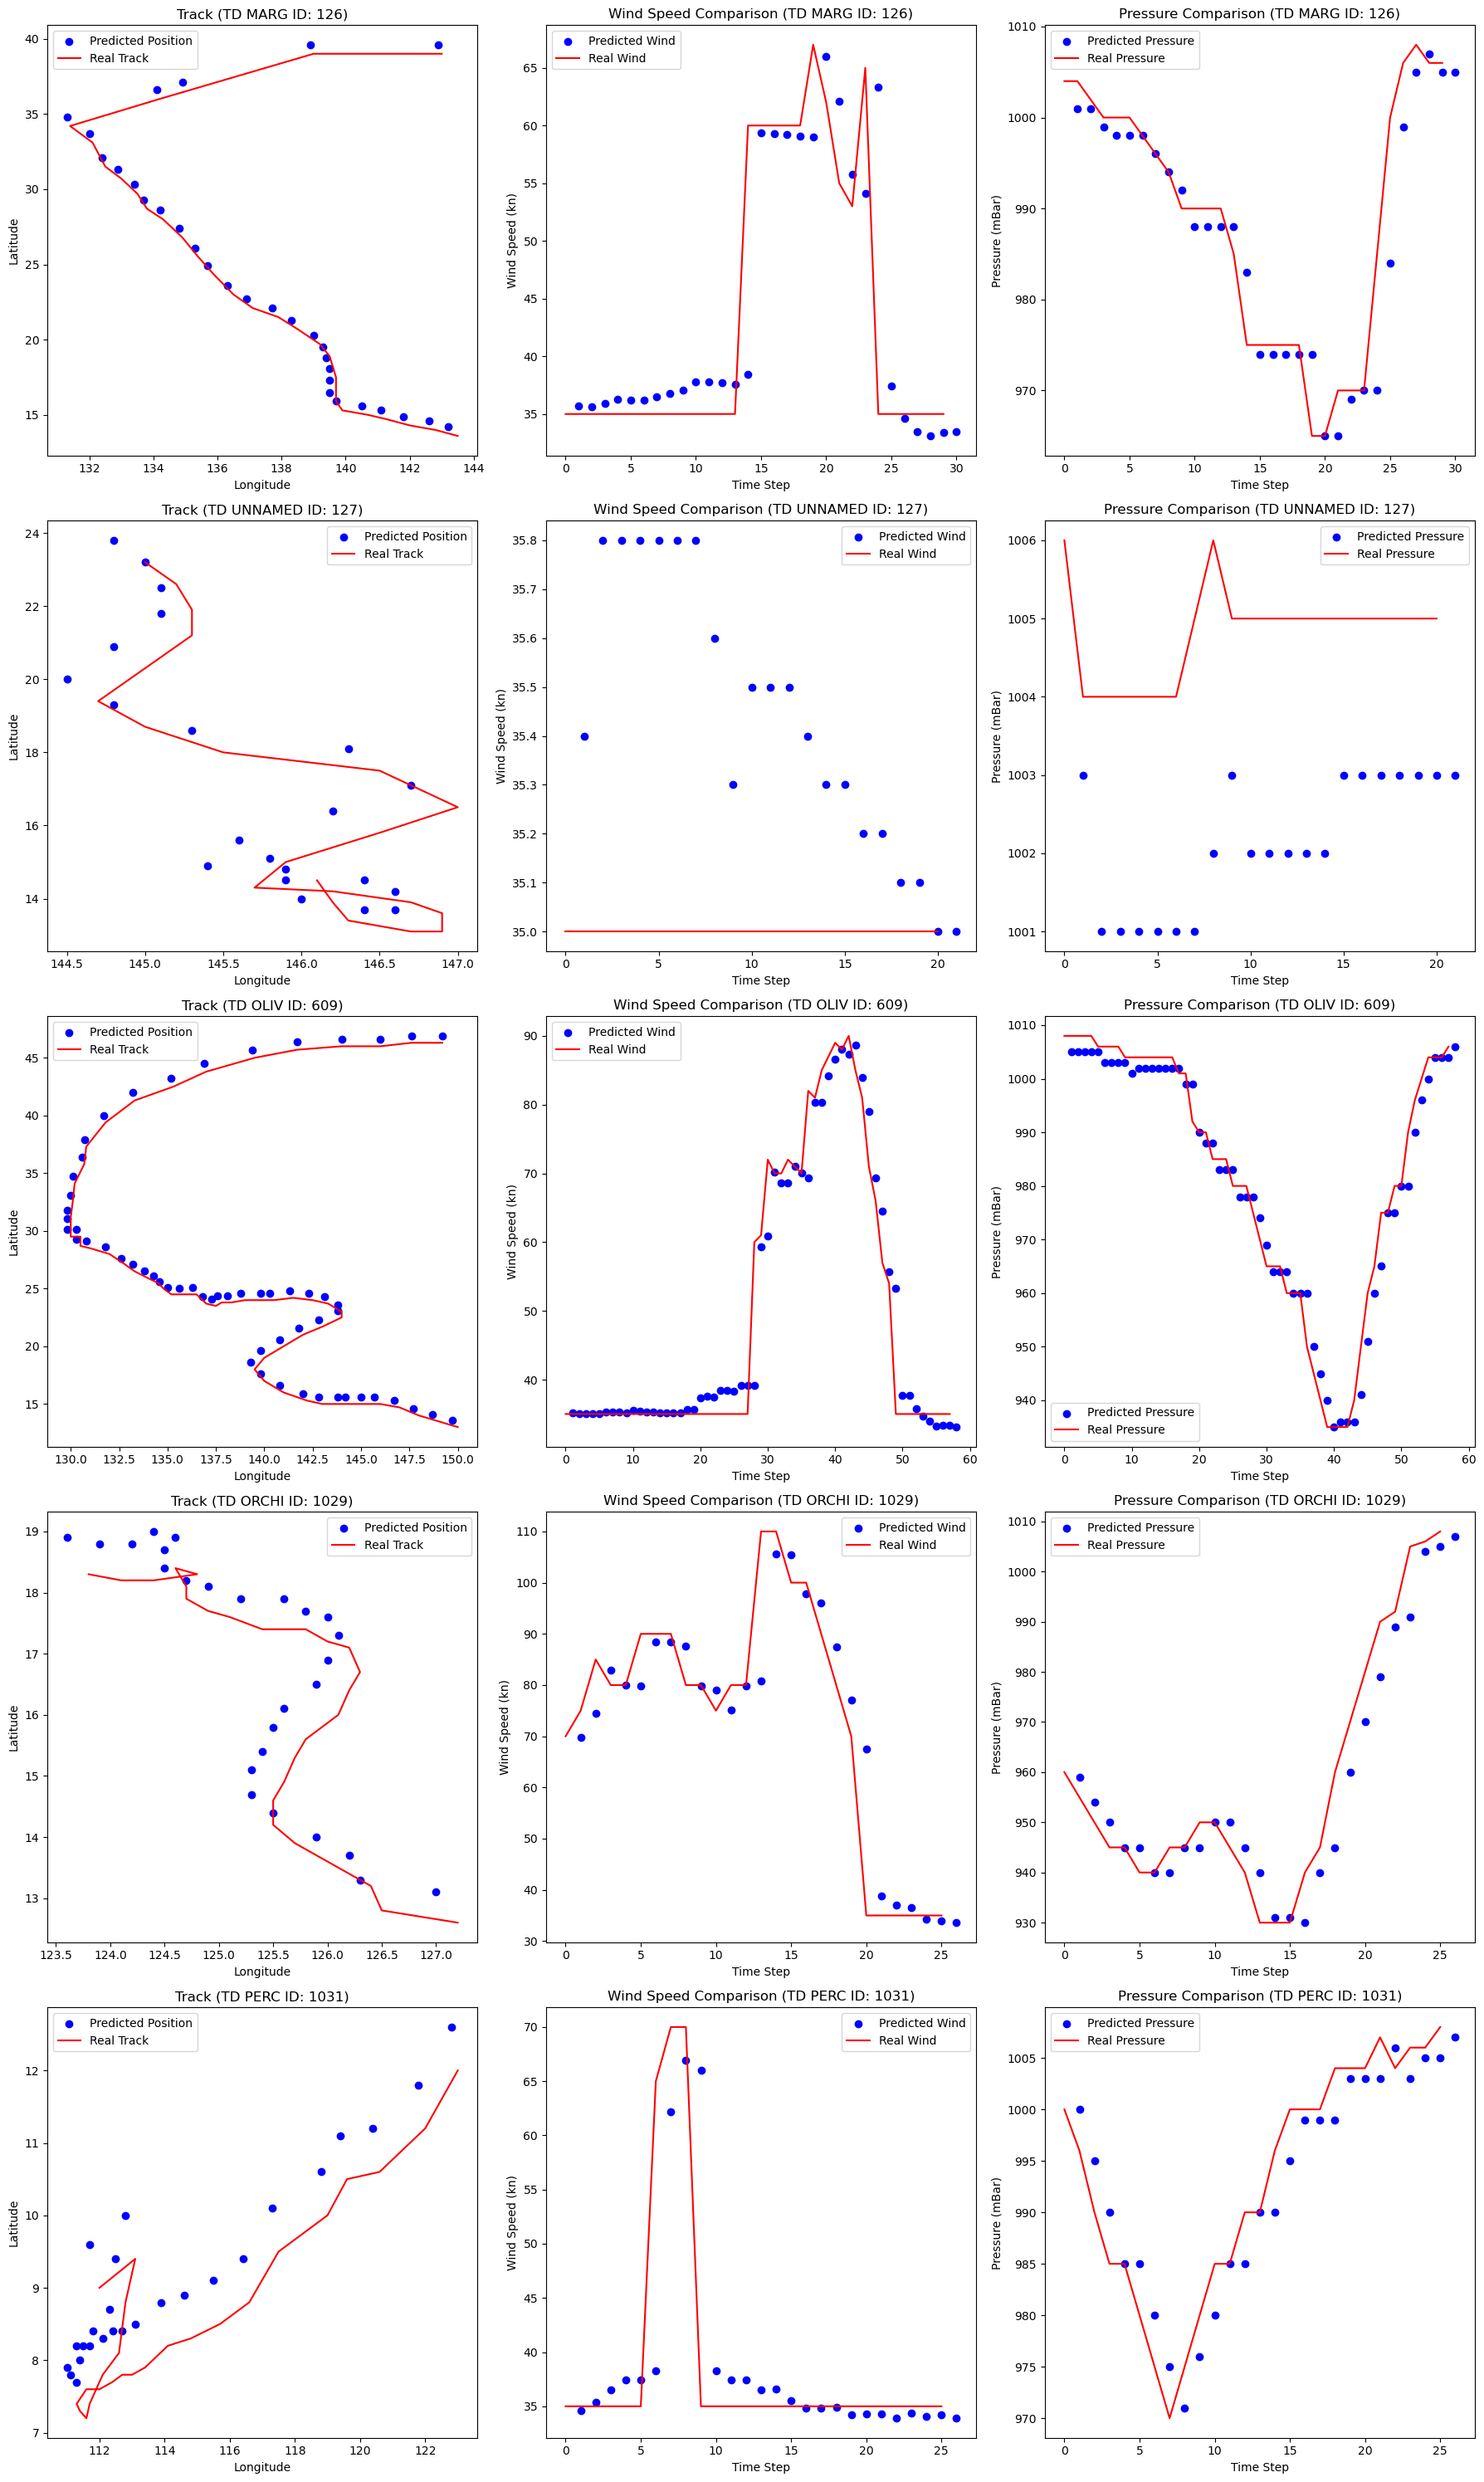

In [16]:
plot_tds(jma, X_test, model=jma_pred_pipeline_sgd, n_samples=3, random_state=97)

In [12]:
df_ = create_real_pred_df(jma, X_test, model=jma_pred_pipeline_sgd, n_samples=3, random_state=97)

C:\Users\Master\PycharmProjects\MachineLearning\Project\utils.py:478: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  groups = df[df.index.isin(samples.index)].group.values


In [13]:
df_ = probability_within_radius(df_, 30)

In [16]:
df_.probability_within_radius.min(), df_.probability_within_radius.max()

(1.2393804414341336e-06, 0.9905699819977108)

In [15]:
df_[df_.group == 609]

,group,name,real_lat,real_lon,real_max_wind_kn,real_min_pressure_mBar,real_velocity_kn,real_direction_deg,pred_lat,pred_lon,pred_max_wind_kn,pred_min_pressure_mBar,expected_velocity_kn,expected_direction_deg,probability_within_radius
date,,,,,,,,,,,,,,,
1971-07-25 06:00:00,609,OLIV,13.5,149.0,35,1008,10.9,297.0,13.6,149.7,35.2,1005.0,327.0,179.0,0.853639
1971-07-25 12:00:00,609,OLIV,14.0,148.0,35,1008,10.9,297.0,14.1,148.7,35.1,1005.0,16.8,311.0,0.854261
1971-07-25 18:00:00,609,OLIV,14.7,147.0,35,1008,12.0,306.0,14.6,147.7,35.1,1005.0,16.7,311.0,0.855035
1971-07-26 00:00:00,609,OLIV,15.0,146.0,35,1008,10.1,287.0,15.3,146.7,35.0,1005.0,18.1,316.0,0.830265
1971-07-26 06:00:00,609,OLIV,15.0,145.3,35,1006,6.8,270.0,15.6,145.7,35.0,1005.0,15.4,306.0,0.842331
1971-07-26 12:00:00,609,OLIV,15.0,144.5,35,1006,7.7,270.0,15.6,145.0,35.3,1003.0,11.4,302.0,0.815327
1971-07-26 18:00:00,609,OLIV,15.0,144.0,35,1006,4.8,270.0,15.6,144.2,35.3,1003.0,12.2,299.0,0.877110
1971-07-27 00:00:00,609,OLIV,15.0,143.0,35,1006,9.7,270.0,15.6,143.8,35.3,1003.0,9.0,312.0,0.693707
1971-07-27 06:00:00,609,OLIV,15.3,142.2,35,1004,8.3,291.0,15.6,142.8,35.2,1003.0,13.0,297.0,0.868775
